# Main of the paper - LSR - $\sigma \neq 0.4$

In this notebook are gathered all experiments generated for the main of the paper using a least-squares regression which require presence of noise.

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, SGD_Descent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.data.RealDatasetPreparation import prepare_quantum
from src.utils.Constants import *
from src.utils.data.DataClustering import *
from src.utils.data.DataPreparation import build_data_linear, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "with_noise"

nb_devices_for_the_run = 20
dim_notebook = 20

In [2]:
# Building data
w_true = generate_param(dim_notebook)
X, Y = build_data_linear(w_true, n_dimensions = dim_notebook, 
                         n_devices=nb_devices_for_the_run, with_seed=False, without_noise=False)
X = add_bias_term(X)
print(X[0].shape)
pickle_saver((X, Y), filename + "-data")

torch.Size([200, 21])


Text(0.5, 1.0, 'Model weights')

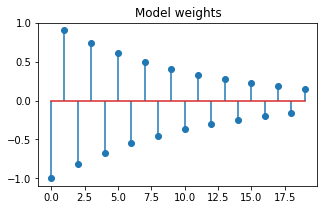

In [3]:
plt.figure(figsize=(5, 3))
plt.stem(w_true, use_line_collection=True)
plt.title("Model weights")

In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [5]:
%%time
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices_for_the_run,
                                                     nb_epoch=2000, 
                                                     momentum=0., 
                                                     verbose=True, 
                                                     cost_models=cost_models,
                                                     stochastic=False,
                                                     bidirectional=False,
                                                    ))
obj_min_by_N_descent.run(cost_models)
obj_min_by_N = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

   it    |   obj   
     400 | 1.3307e-01
     800 | 1.3307e-01
    1200 | 1.3307e-01
    1600 | 1.3307e-01
Gradient Descent: execution time=68.188 seconds
Final loss : 0.13307

CPU times: user 16.9 s, sys: 0 ns, total: 16.9 s
Wall time: 1min 8s


In [6]:
obj_min_by_N_descent.model_params[-1]

tensor([ 1.9010, -0.9994,  0.9059, -0.8294,  0.7473, -0.6719,  0.5935, -0.5437,
         0.5036, -0.4507,  0.4132, -0.3852,  0.3425, -0.2942,  0.2733, -0.2496,
         0.2315, -0.1953,  0.1673, -0.1622,  0.1579], dtype=torch.float64)

In [7]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               step_formula=deacreasing_step_size,
                                               compression_model = SQuantization(1, dim_notebook+1))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [3:09:25<00:00, 2273.01s/it]


CPU times: user 1h 11min 45s, sys: 9.6 s, total: 1h 11min 54s
Wall time: 3h 9min 25s


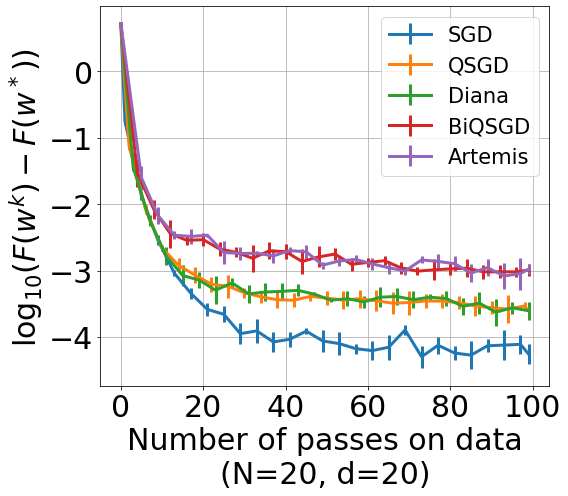

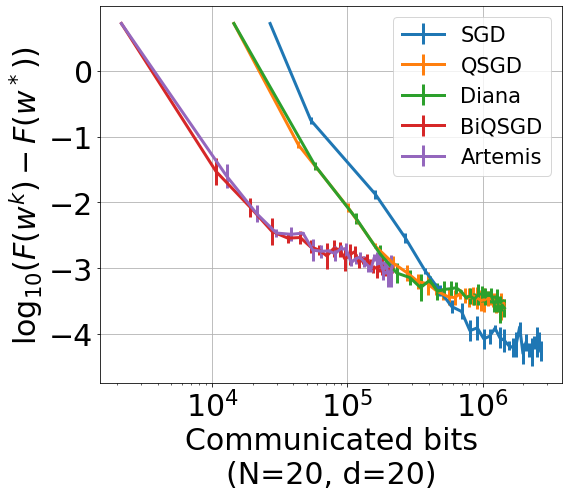

In [8]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  


## Devices sampling

In [9]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               step_formula=deacreasing_step_size, fraction_sampled_workers=0.5,
                                              compression_model = SQuantization(1, dim_notebook+1))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [1:33:52<00:00, 1126.56s/it]


CPU times: user 43min 42s, sys: 5.66 s, total: 43min 48s
Wall time: 1h 33min 53s


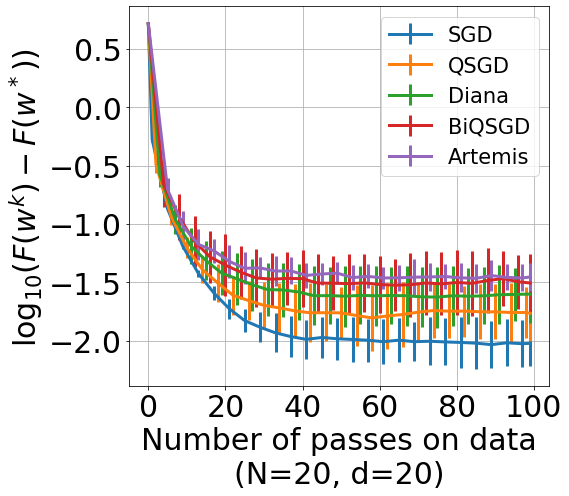

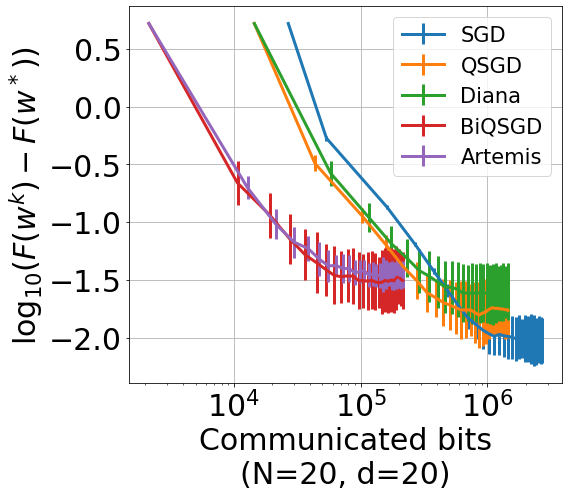

In [10]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  
